<a href="https://colab.research.google.com/github/Diego-II/DeepLearning/blob/master/Tarea4/Respuestas_Tarea_4_ConvNet_CC6204_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 4: Redes Convolucionales <br/> CC6204 Deep Learning, Universidad de Chile <br/> Hoja de Respuestas

## Nombre: 
Fecha de entrega: 11 de diciembre de 2020

In [ ]:
import os
import sys
import random
import pickle

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial import distance

import torchvision
import torchvision.transforms as transforms

# Aqui descargamos algunas funciones utiles para resolver la tarea
if not os.path.exists('utils.py'):
  !wget https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py

!pip install torchsummary
from torchsummary import summary

from utils import ImageCaptionDataset, train_for_classification, train_for_retrieval

!pip install ipdb
import ipdb

--2020-12-14 20:40:43--  https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea4/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7403 (7.2K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   7.23K  --.-KB/s    in 0s      

2020-12-14 20:40:43 (99.6 MB/s) - ‘utils.py’ saved [7403/7403]

  Created wheel for ipdb: filename=ipdb-0.13.4-cp36-none-any.whl size=10971 sha256=37a33d93b3606502e8d3c5ee10f129e1446605f20d92420212d513beb91e15e2
  Stored in directory: /root/.cache/pip/wheels/56/51/e4/c91c61e3481a1a967beb18c4ea7a2b138a63cce94170b2e206
Successfully built ipdb


In [ ]:
# Aqui instalamos la libreria de correccion del curso
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# En caso que se les indique, cambia el host y port que posteamos en u-cursos
corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# En caso que se les indique, cambia el token que te daremos en u-cursos
token = "]ye/Ox;nsz"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-w_w942ft/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-w_w942ft/cc6204
  Created wheel for cc6204: filename=cc6204-0.5.0-cp36-none-any.whl size=5800 sha256=e7ab84684aff435defdd989d33b1800714ee49f62a7c76aae1d387f51e4bbef9
  Stored in directory: /tmp/pip-ephem-wheel-cache-0qf7hh1f/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
Connection stablished


In [ ]:
import matplotlib.pyplot as plt

def plot_results(loss, score1, score1_title='Accuracy', score2=None, score2_title=None):
  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  ax1.legend(['train-loss'])
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title(score1_title)    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel(score1_title.lower())
  ax2.plot(score1[0], c='b')
  ax2.plot(score1[1], c='g')
  ax2.legend([f'train-{score1_title.lower()}', f'val-{score1_title.lower()}'])
  f2.show()

  if score2:
    f3= plt.figure(3)
    ax3 = f3.add_subplot(111)
    ax3.set_title(score2_title)    
    ax3.set_xlabel('epochs')
    ax3.set_ylabel(score2_title.lower())
    ax3.plot(score2[0], c='b')
    ax3.plot(score2[1], c='g')
    ax3.legend([f'train-{score2_title.lower()}', f'val-{score2_title.lower()}'])
    f3.show()

# Parte 1: Arquitectura Convolucional GoogLeNet (y otras) para CIFAR10

## 1a) Inception Module

In [ ]:
# Como todas las capas convolucionales del paper usan ReLu, se va a hacer una clase general para facilitar esto:
class Conv2dRelu(nn.Module):
  def __init__(
      self, 
      in_channels,
      out_channels, 
      **kwargs
  ):
    super(Conv2dRelu, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)

  def forward(self, x):
    x = self.conv(x)
    return F.relu(x)

In [ ]:
class InceptionModule(nn.Module):
  def __init__(self, 
               in_channels, 
               ch_3x3_reduce=96, 
               ch_5x5_reduce=16,
               ch_3x3=128,
               ch_5x5=32,
               ch_pool_proj=32,
               ch_1x1=64
    ):
    super(InceptionModule, self).__init__()
    # Acá inicializa todos los parámetros
    # Rama 1: Conv2d 1x1 -> Conv2d 3x3
    self.branch1 = nn.Sequential(
        Conv2dRelu(in_channels, ch_3x3_reduce, kernel_size=1),
        Conv2dRelu(ch_3x3_reduce, ch_3x3, kernel_size=3, padding=1)
    )
    # Rama 2: Conv2dRelu 1x1 -> Conv2dRelu 5x5
    self.branch2 = nn.Sequential(
        Conv2dRelu(in_channels, ch_5x5_reduce, kernel_size=1),
        Conv2dRelu(ch_5x5_reduce, ch_5x5, kernel_size=5, padding=2)
    )

    # Rama 3: Max_Pool -> Conv2dRelu 1x1
    self.branch3 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
        Conv2dRelu(in_channels, ch_pool_proj, kernel_size=1)
    )

    # Rama 4: Conv2dRelu 1x1
    self.branch4 = Conv2dRelu(in_channels, ch_1x1, kernel_size=1)
        

  def _forward(self, x):
    # aux para forward:
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)

    outputs = [branch1, branch2, branch3, branch4]
    return outputs


  def forward(self, x):
    # Calcula la salida como un tensor con cantidad de canales de
    # salida dado por ch_3x3 + ch_5x5 + ch_pool_proj + ch_1x1
    outputs = self._forward(x)
    return torch.cat(outputs, 1)

Esta celda se utiliza para chequear que los tamanos del output sean los correctos.

In [ ]:
# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

with torch.no_grad():
  model = InceptionModule(in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj)
  s = timer()
  result = model._forward(torch.tensor(x))
  for r in result:
    print(r.shape)

torch.Size([5, 128, 28, 28])
torch.Size([5, 16, 28, 28])
torch.Size([5, 32, 28, 28])
torch.Size([5, 32, 28, 28])


In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, in_chs, ch_1x1, ch_3x3_red, ch_3x3, ch_5x5_red, ch_5x5, ch_pool_proj = corrector.get_test_data(homework=4, question="1a", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = InceptionModule(in_chs, ch_3x3_red, ch_5x5_red, ch_3x3, ch_5x5, ch_pool_proj, ch_1x1)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
corrector.submit(homework=4, question="1a", test=1, token=token, answer=list(result.size()), time=t)

Using cached test data
Correct Test!


## 1b) GoogLeNet

In [ ]:
# Modulo auxiliar de prediccion intermedia:
class InceptionAux(nn.Module):
  def __init__(
      self, 
      in_channels, 
      num_classes
  ):
    super(InceptionAux,self).__init__()
    #self.avgpool = nn.AvgPool2d(kernel_size= 5,stride=3)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.conv = Conv2dRelu(in_channels, 128, kernel_size=1)

    self.fc1 = nn.Linear(128,1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.avgpool(x)
    x = self.conv(x)
    x = torch.flatten(x,1)
    x = self.fc1(x)
    x = F.relu(x, inplace=True)
    x = F.dropout(x, 0.7, training=self.training)
    x = self.fc2(x)

    return x


In [ ]:
# basado en la documentacion de Pytorch/Vision/GoogLeNet. 
class GoogLeNet(nn.Module):
  def __init__(self, n_classes, use_aux_logits=True):
    super(GoogLeNet, self).__init__()
    self.use_aux_logits = use_aux_logits
    # Define las capas de convolución y pooling de GoogLeNet
    # Conv 1
    self.conv1 = Conv2dRelu(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
    # Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
    
    # Conv 2
    self.conv2 = Conv2dRelu(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
    # Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    # in_channels, ch_3x3_reduce=96, ch_5x5_reduce=16,
    # ch_3x3=128, ch_5x5=32, ch_pool_proj=32, ch_1x1=64

    # Inception 3a
    self.inception3a = InceptionModule(in_channels=192, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=128, ch_5x5=32, ch_pool_proj=32, ch_1x1=64)
    # Inception 3b
    self.inception3b = InceptionModule(in_channels=256, ch_3x3_reduce=128, ch_5x5_reduce=32, ch_3x3=192, ch_5x5=96, ch_pool_proj=64, ch_1x1=128)

    # Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    # Inception 4a
    self.inception4a = InceptionModule(in_channels=480, ch_3x3_reduce=96, ch_5x5_reduce=16, ch_3x3=208, ch_5x5=48, ch_pool_proj=64, ch_1x1=192)
    # Inception 4b
    self.inception4b = InceptionModule(in_channels=512, ch_3x3_reduce=112, ch_5x5_reduce=24, ch_3x3=224, ch_5x5=64, ch_pool_proj=64, ch_1x1=160)
    # Inception 4c
    self.inception4c = InceptionModule(in_channels=512, ch_3x3_reduce=128, ch_5x5_reduce=24, ch_3x3=256, ch_5x5=64, ch_pool_proj=64, ch_1x1=128)
    # Inception 4d
    self.inception4d = InceptionModule(in_channels=512, ch_3x3_reduce=144, ch_5x5_reduce=32, ch_3x3=288, ch_5x5=64, ch_pool_proj=64, ch_1x1=112)
    # Inception 4e
    self.inception4e = InceptionModule(in_channels=528, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)

    # Max Pool 4
    self.maxpool4  = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

    # Inception 5a
    self.inception5a = InceptionModule(in_channels=832, ch_3x3_reduce=160, ch_5x5_reduce=32, ch_3x3=320, ch_5x5=128, ch_pool_proj=128, ch_1x1=256)
    # Inception 5b
    self.inception5b = InceptionModule(in_channels=832, ch_3x3_reduce=192, ch_5x5_reduce=48, ch_3x3=384, ch_5x5=128, ch_pool_proj=128, ch_1x1=384)

    # Avg Pool
    #self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    # Dropout .4
    self.dropout = nn.Dropout2d(0.4)

    # Linear
    # Capa de salida (antes de la función de salida)
    self.fc_out = nn.Linear(1024, n_classes)

    # Decide si usar la clasificación auxiliar
    if self.use_aux_logits:
      self.aux1 = InceptionAux(512, n_classes)
      self.aux2 = InceptionAux(528, n_classes)
    else:
      self.aux1 = None  # type: ignore[assignment]
      self.aux2 = None

  def forward(self, x):
    if self.use_aux_logits and self.training:
      aux_logits = []
    else:
      aux_logits = None
    x = self.conv1(x)
    
    x = self.maxpool1(x)
    
    x = self.conv2(x)
    
    x = self.maxpool2(x)


    x = self.inception3a(x)
  
    x = self.inception3b(x)

    x = self.maxpool3(x)
    
    x = self.inception4a(x)

    # Crea una lista para los logits auxiliares si fuera necesario
    if self.use_aux_logits:
      if self.training:
        aux1_out = self.aux1(x)
        aux_logits.append(aux1_out)
    else:
      aux1_out = None
    

    x = self.inception4b(x)
    
    x = self.inception4c(x)
    
    x = self.inception4d(x)

    # Si se usa la clasificación auxiliar, computa logits auxiliares
    if self.use_aux_logits:
      if self.training:
        aux2_out = self.aux2(x)
        aux_logits.append(aux2_out)
    else:
      aux2_out = None

    # Continúa computando las representaciones internas de la red
    x = self.inception4e(x)
    
    x = self.maxpool4(x)


    x = self.inception5a(x)

    hidden = torch.squeeze(x)

    # hidden = self.hidden_fc(hidden)

    x = self.inception5b(x)
    

    x = self.avgpool(x)
    
    x = torch.flatten(x, 1)
    
    x = self.dropout(x)
    x = self.fc_out(x)
    
    #return x, aux2_out, aux1_out

    # En hidden debes devolver alguna de las capas oculta de la red
    return {'hidden': hidden, 'logits': x, 'aux_logits': aux_logits}

In [ ]:
ver_resumen = True
if ver_resumen:
  device = 'cuda'
  # Instanciamos la red
  test_model = GoogLeNet(n_classes=1000, use_aux_logits=True).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
        Conv2dRelu-2           [-1, 64, 16, 16]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,592
        Conv2dRelu-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 4, 4]               0
            Conv2d-7             [-1, 96, 4, 4]          18,432
        Conv2dRelu-8             [-1, 96, 4, 4]               0
            Conv2d-9            [-1, 128, 4, 4]         110,592
       Conv2dRelu-10            [-1, 128, 4, 4]               0
           Conv2d-11             [-1, 16, 4, 4]           3,072
       Conv2dRelu-12             [-1, 16, 4, 4]               0
           Conv2d-13             [-1, 32, 4, 4]          12,800
       Conv2dRelu-14             [-1, 3

In [ ]:
# Tests del API del curso para el InceptionModule

# Obtengamos algunos parametros para probar tu implementación
x, n_classes, use_aux_logits = corrector.get_test_data(homework=4, question="1b", test=1, token=token)

# Corramos tu implementación de InseptionModule para ver como se comporta
with torch.no_grad():
  model = GoogLeNet(n_classes=n_classes, use_aux_logits=True)
  s = timer()
  result = model(torch.tensor(x))
  t = timer()-s

# Veamos si todo fue OK :)
sizes = [result['hidden'].shape[0]] + list(result['logits'].size()) + [d for a in result['aux_logits'] for d in a.size()]
corrector.submit(homework=4, question="1b", test=1, token=token, answer=sizes, time=t)

Correct Test!


## 1c) DenseNet
https://arxiv.org/pdf/1608.06993.pdf

Se debe destacar que adicionalmente se intento implementar la red `ResNet` y hacer transferencia de aprendizaje. Como fue copy paste, se decidio implementar `DenseNet` que era mas sencilla. 

Se deja de todas formas el link a la `ResNet` implementada, que obtuvo mucho mejor resultado: [Repo con ResNet.](https://github.com/Diego-II/DeepLearning/blob/master/Tarea4/Respuestas_Tarea_4_ConvNet_CC6204_2020.ipynb)

Cabe destacar que el paper y repositorio de donde se saco utilizaba pocas imagenes para el fine tuning, 5 por clases logrando accuracy superior al 90% ([Big Transfer](https://paperswithcode.com/paper/large-scale-learning-of-general-visual)). 


In [ ]:
class Conv2dBnRelu(nn.Module):
  def __init__(
      self, 
      in_channels,
      out_channels, 
      **kwargs
  ):  
    super(Conv2dBnRelu, self).__init__()
    self.bn = nn.BatchNorm2d(in_channels)
    self.conv = nn.Conv2d(in_channels, out_channels, bias = False,**kwargs)

  def forward(self, x):
    x = self.conv(F.relu(self.bn(x)))
    return x

In [ ]:
ver_resumen_dense_layer = True
if ver_resumen_dense_layer:
  device = 'cuda'
  # Instanciamos la red
  test_model = Conv2dBnRelu(3, 3, kernel_size=3, padding=1).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2            [-1, 3, 32, 32]              81
Total params: 87
Trainable params: 87
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [ ]:
# Vamos primero con el Dense Block
class DenseConv(nn.Module):
  def __init__(self, in_channels, growth_rate):
    super(DenseConv, self).__init__()
    self.conv1 = Conv2dBnRelu(in_channels, 4*growth_rate, kernel_size=1, stride=1)
    self.conv2 = Conv2dBnRelu(4*growth_rate, growth_rate, kernel_size=3, padding=1, stride=1)


  def forward(self, x):
    out = self.conv2(self.conv1(x))
    return torch.cat([out, x], 1)

In [ ]:
ver_resumen_dense_conv = True
if ver_resumen_dense_conv:
  device = 'cuda'
  # Instanciamos la red
  test_model = DenseConv(3, 12).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 48, 32, 32]             144
      Conv2dBnRelu-3           [-1, 48, 32, 32]               0
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
      Conv2dBnRelu-6           [-1, 12, 32, 32]               0
Total params: 5,430
Trainable params: 5,430
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.34
Params size (MB): 0.02
Estimated Total Size (MB): 1.37
----------------------------------------------------------------


In [ ]:
class DenseLayer(nn.Module):
  def __init__(self, num_layers, in_channels, growth_rate):
    super(DenseLayer, self).__init__()
    self.layer = nn.Sequential()
    for i in range(num_layers):
      layer = DenseConv(
          in_channels=in_channels + i * growth_rate,
          growth_rate = growth_rate
      )
      self.layer.add_module('denselayer%d' % (i + 1), layer)

  def forward(self, x):
    x = self.layer(x)
    return x

In [ ]:
ver_resumen_dense_layer = True
if ver_resumen_dense_layer:
  device = 'cuda'
  # Instanciamos la red
  test_model = DenseLayer(4, 3, 12).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 48, 32, 32]             144
      Conv2dBnRelu-3           [-1, 48, 32, 32]               0
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
      Conv2dBnRelu-6           [-1, 12, 32, 32]               0
         DenseConv-7           [-1, 15, 32, 32]               0
       BatchNorm2d-8           [-1, 15, 32, 32]              30
            Conv2d-9           [-1, 48, 32, 32]             720
     Conv2dBnRelu-10           [-1, 48, 32, 32]               0
      BatchNorm2d-11           [-1, 48, 32, 32]              96
           Conv2d-12           [-1, 12, 32, 32]           5,184
     Conv2dBnRelu-13           [-1, 12, 32, 32]               0
        DenseConv-14           [-1, 27,

In [ ]:
class TransitionLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TransitionLayer, self).__init__()
    self.conv = Conv2dBnRelu(in_channels, out_channels, kernel_size =1, stride=1)
    self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
  
  def forward(self, x):
    x = self.avgpool(self.conv(x))
    return x

In [ ]:
ver_resumen_transition_layer = True
if ver_resumen_transition_layer:
  device = 'cuda'
  # Instanciamos la red
  test_model = TransitionLayer(3, 12).to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 12, 32, 32]              36
      Conv2dBnRelu-3           [-1, 12, 32, 32]               0
         AvgPool2d-4           [-1, 12, 16, 16]               0
Total params: 42
Trainable params: 42
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.23
Params size (MB): 0.00
Estimated Total Size (MB): 0.25
----------------------------------------------------------------


In [ ]:
class DenseNet(nn.Module):
  def __init__(self, num_init_filters=32, blocks = None, growth_rate=12, n_classes=10):
    super(DenseNet, self).__init__()
    self.gr = growth_rate
    if blocks is None:
      blocks = [6,12,24,16]
    self.blocks = blocks
    self.input_layer = nn.Sequential(
        Conv2dBnRelu(in_channels = 3, out_channels=num_init_filters, kernel_size=7, stride = 2, padding = 3),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    
    self.body = nn.Sequential()
    features_num = num_init_filters
    for i, b in enumerate(self.blocks):
      block = DenseLayer(
          num_layers = b, 
          in_channels = features_num,
          growth_rate = self.gr
      )
      self.body.add_module('denseblock%d' % (i + 1), block)
      features_num = features_num + b * growth_rate

      if i  != len(self.blocks) - 1:
        transition = TransitionLayer(
            in_channels = features_num,
            out_channels = features_num // 2
        )
        self.body.add_module('transition%d' % (i + 1), transition)
        features_num = features_num // 2
    
    # self.final_pool = nn.AdaptiveAvgPool2d((7, 7))

    self.classifier = nn.Linear(features_num, n_classes)

  def forward(self, x):
    x = self.input_layer(x)
    out = self.body(x)
    hidden = torch.squeeze(out)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    out = self.classifier(out)
    
    return {'hidden': hidden, 'logits': out}


In [ ]:
ver_resumen_densenet = True
if ver_resumen_densenet:
  device = 'cuda'
  # Instanciamos la red
  test_model = DenseNet().to(device)
  # Le pasamos un tensor de prueba para verificar que las dimensiones esten bien
  summary(test_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 32, 16, 16]           4,704
      Conv2dBnRelu-3           [-1, 32, 16, 16]               0
         MaxPool2d-4             [-1, 32, 8, 8]               0
       BatchNorm2d-5             [-1, 32, 8, 8]              64
            Conv2d-6             [-1, 48, 8, 8]           1,536
      Conv2dBnRelu-7             [-1, 48, 8, 8]               0
       BatchNorm2d-8             [-1, 48, 8, 8]              96
            Conv2d-9             [-1, 12, 8, 8]           5,184
     Conv2dBnRelu-10             [-1, 12, 8, 8]               0
        DenseConv-11             [-1, 44, 8, 8]               0
      BatchNorm2d-12             [-1, 44, 8, 8]              88
           Conv2d-13             [-1, 48, 8, 8]           2,112
     Conv2dBnRelu-14             [-1, 4

In [ ]:
test_model.parameters

<bound method Module.parameters of DenseNet(
  (input_layer): Sequential(
    (0): Conv2dBnRelu(
      (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (denseblock1): DenseLayer(
      (layer): Sequential(
        (denselayer1): DenseConv(
          (conv1): Conv2dBnRelu(
            (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (conv2): Conv2dBnRelu(
            (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
        )
        (denselayer2): DenseConv(
   

## 1d) Clasificación de Imágenes en CIFAR10

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las celdas tendrás los datos 
# trainset, trainloader y similar para test.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Se utilizara el siguiente `lr_scheduler`:
 [CosineAnnealingLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.CosineAnnealingLR). 

Este se propone en el paper [SGDR: STOCHASTIC GRADIENT DESCENT WITH WARM RESTARTS](https://arxiv.org/pdf/1608.03983.pdf). En este, afirman que utilizando los `Warm Restarts`, se pueden lograr resultados competitivos en `CIFAR10` y `CIFAR100` aproximadamente dos a cuatro veces mas rapido. 


In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.003
EPOCHS = 30
REPORTS_EVERY = 1

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

google_net =  GoogLeNet(n_classes=10, use_aux_logits=True)# tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.Adam(google_net.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...


criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))
# (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

# ipdb.set_trace()
train_loss, acc = train_for_classification(google_net, train_loader, test_loader, optimizer, criterion, lr_scheduler=scheduler, epochs=EPOCHS)

plot_results(train_loss, acc)

Epoch:1(50000/50000), lr:0.0030000, Loss:1.55936, Train Acc:42.4%, Validating..., Val Acc:53.20%, Avg-Time:168.362s.
Epoch:2(50000/50000), lr:0.0030000, Loss:1.09657, Train Acc:60.8%, Validating..., Val Acc:60.29%, Avg-Time:169.126s.
Epoch:3(50000/50000), lr:0.0030000, Loss:0.88915, Train Acc:68.8%, Validating..., Val Acc:67.75%, Avg-Time:169.480s.
Epoch:4(50000/50000), lr:0.0030000, Loss:0.77182, Train Acc:72.9%, Validating..., Val Acc:72.16%, Avg-Time:169.129s.
Epoch:5(50000/50000), lr:0.0030000, Loss:0.69017, Train Acc:75.9%, Validating..., Val Acc:70.96%, Avg-Time:169.299s.
Epoch:6(50000/50000), lr:0.0029999, Loss:0.62152, Train Acc:78.4%, Validating..., Val Acc:75.37%, Avg-Time:170.308s.
Epoch:7(50000/50000), lr:0.0029999, Loss:0.56616, Train Acc:80.2%, Validating..., Val Acc:76.38%, Avg-Time:170.818s.
Epoch:8(50000/50000), lr:0.0029999, Loss:0.51388, Train Acc:82.0%, Validating..., Val Acc:75.69%, Avg-Time:170.410s.
Epoch:9(50000/50000), lr:0.0029998, Loss:0.47240, Train Acc:83.4

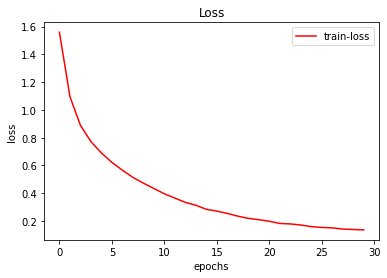

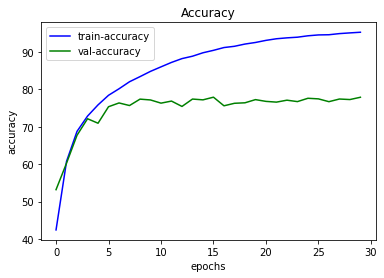

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = 32
LR = 0.003
EPOCHS = 30
REPORTS_EVERY = 1

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

dense_net =  DenseNet(num_init_filters=64)# tu modelo de CNN (para clasificar en 10 clases)
optimizer = optim.Adam(dense_net.parameters(), lr=LR) # optimizador, e.g., optim.SGD, optim.Adam, ...


criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))
# (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

# ipdb.set_trace()
train_loss, acc = train_for_classification(dense_net, train_loader, test_loader, optimizer, criterion ,lr_scheduler=scheduler, epochs=EPOCHS)

plot_results(train_loss, acc)

In [ ]:
# Test
x, y = list(test_loader)[0]
net.cpu()
net.eval()
y_pred = net(x)['logits'].max(dim=1)[1]

# Veamos como se comporta el modelo
print("Correct Test!" if (y==y_pred).sum()/len(x) >= .75 else "Failed Test! [acc]")

Correct Test!


## 1e) Opcional: CIFAR100

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para CIFAR100.
##############################################################################

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                         download=True, transform=transform)

testset = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                        download=True, transform=transform)

In [ ]:
# Definamos algunos hiper-parámetros
BATCH_SIZE = ...
LR = ...
EPOCHS = ...
REPORTS_EVERY = 1

net = ... # tu modelo de CNN (para clasificar en 100 clases)
optimizer = ... # optimizador, e.g., optim.SGD, optim.Adam, ...
criterion = nn.CrossEntropyLoss() # función de pérdida
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos para ajustar el lr según el número de épocas

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=4*BATCH_SIZE,
                         shuffle=False, num_workers=2)

train_loss, acc = train_for_classification(net, train_loader, 
                                           test_loader, optimizer, 
                                           criterion, lr_scheduler=scheduler, 
                                           epochs=EPOCHS, reports_every=REPORTS_EVERY)

plot_results(train_loss, acc)

# Parte 2: Subtitulado de Imágenes mediante Recuperación de Textos

## 2a) Codificación de Imágenes y Textos

Veamos el tamano de las salidas de las capas ocultas:

In [ ]:
# GoogleNet HiddenSize:
dense_net = DenseNet()
out = dense_net(torch.randn(5,3,32,32))
hid = out['hidden']
hid_flt = torch.squeeze(hid)
print(hid.size())
print(hid_flt.size())

torch.Size([5, 385])
torch.Size([5, 385])


In [ ]:
# DenseNet HiddenSize:
google_net = GoogLeNet(10)
out = google_net(torch.randn(9,3,32,32))
hid = out['hidden']
hid_flt = torch.squeeze(hid)
print(hid.size())
print(hid_flt.size())

torch.Size([9, 832])
torch.Size([9, 832])


In [ ]:
class MyLinear(nn.Module):
  def __init__(self, in_features, out_features, bias=False):
    super(MyLinear, self).__init__()
    self.linear = nn.Linear(in_features, out_features, bias)

  def forward(self, x):
    return F.relu(self.linear(x))

In [ ]:
class ImageEncoding(nn.Module):
  def __init__(self, cnn_model, h_size, out_size=128):
    super(ImageEncoding, self).__init__()
    self.cnn_model = cnn_model

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.mlp = nn.Sequential(
        MyLinear(h_size, 512),
        nn.Dropout(.4),
        MyLinear(512, 128)
    )

  def forward(self, x):
    out = self.cnn_model(x)['hidden']
    #out = torch.flatten(out)
    
    # Compute las capas de su MLP
    out = self.mlp(out)

    # En fc_out debe almacenar el encoding en R^d
    return {'logits': out}

In [ ]:
# probemos con la DenseNet que el paso forward funciona
dense_net = DenseNet()
test_model = ImageEncoding(dense_net, 385).cpu()
test_model.eval()


out_img_encoding = test_model(torch.randn(5,3,32,32))['logits']
out_img_encoding.size()

torch.Size([5, 128])

In [ ]:
# probemos con la googlenet que el paso forward funciona
net_google = GoogLeNet(10)
test_model = ImageEncoding(net_google, 832).cpu()
test_model.eval()


out_img_encoding = test_model(torch.randn(5,3,32,32))['logits']
out_img_encoding.size()

torch.Size([5, 128])

In [ ]:
class TextEncoding(nn.Module):
  def __init__(self, text_embedding_size=4096, out_size=128, use_last_bn = True):
    super(TextEncoding, self).__init__()

    # Defina las capas de su MLP
    # Hints: no usar más de 3 capas
    #        incorpora alguna técnica de regularización que ya conoces
    self.text_embedding_size = text_embedding_size
    self.out_size = out_size
    self.mlp = nn.Sequential(
        MyLinear(in_features = self.text_embedding_size, out_features = 512), 
        nn.Dropout(.4),
        MyLinear(in_features = 512, out_features = self.out_size)
    )

    self.use_last_bn = use_last_bn
    if use_last_bn:
      self.bn = nn.BatchNorm1d(out_size)

  def forward(self, x):
    # Compute las capas de su MLP
    x = self.mlp(x)
    if self.use_last_bn:
      x = self.bn(x)

    # En logits debe almacenar el encoding en R^d
    return {'logits': x}

In [ ]:
# Test
OUT_SIZE = 128

GoogLeNet_OUTSIZE = 832
DenseNet_OUTSIZE = 385

cnn_net = GoogLeNet(10)
# cnn_model, h_size, out_size=128
i_enc = ImageEncoding(cnn_model=cnn_net, h_size=GoogLeNet_OUTSIZE, out_size=OUT_SIZE)
t_enc = TextEncoding(text_embedding_size=4096, out_size=OUT_SIZE)
i_enc.eval()
t_enc.eval()

# Veamos como se comportan tus encoders
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size()==t_enc(torch.randn(9,4096))['logits'].size()) else "Failed Test [size]")
print("Correct Test!" if (i_enc(torch.randn(9,3,32,32))['logits'].size(-1)==OUT_SIZE) else "Failed Test [size]")

Correct Test!
Correct Test!


## 2b) Buenas codificaciones y la *Triplet Loss*

In [ ]:
pdist = nn.PairwiseDistance(p=2)
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
output = pdist(input1, input2)
print(output)

tensor([16.3996, 13.4305, 16.5881, 15.0861, 15.7949, 14.3291, 17.0469, 16.1085,
        16.6626, 15.3399, 15.0420, 16.2189, 17.0659, 15.6073, 17.0010, 16.6941,
        17.3918, 15.9959, 15.3743, 18.0246, 18.4970, 14.8071, 18.6857, 14.6050,
        16.5045, 15.6976, 14.4642, 15.5031, 16.5776, 14.9224, 16.2588, 16.9235,
        18.2406, 15.7734, 18.3543, 16.2997, 15.9321, 14.5393, 15.6001, 17.1503,
        15.2988, 13.8244, 14.8622, 16.1094, 15.6718, 15.5798, 15.1867, 16.8580,
        17.5233, 17.2528, 15.8658, 17.4255, 14.9044, 14.2488, 17.1107, 15.9137,
        15.4323, 16.5090, 15.3060, 15.8790, 14.5192, 15.3147, 15.9483, 16.5834,
        15.9351, 15.5770, 14.5295, 15.4038, 14.2643, 14.3022, 16.9299, 17.1579,
        16.4328, 16.3215, 14.7421, 15.9415, 16.1368, 17.2639, 14.8565, 16.8516,
        14.9594, 16.4587, 15.1997, 15.4530, 15.9357, 15.7209, 16.7578, 15.9328,
        16.0558, 15.1767, 15.6110, 16.2211, 16.5736, 15.9570, 15.5426, 16.4253,
        17.7073, 16.0455, 16.4800, 16.77

In [ ]:
class TripletLoss(nn.Module):
  def __init__(self, margin=.2, negative='max'):
    super(TripletLoss, self).__init__()
    self.margin = margin
    self.negative = negative

  def forward(self, anchor, positive):
    # Posiblemente lo más simple es partir calculando la distancia Euclideana
    # entre las imagenes ancla y todos los pares (B x B) de representaciones
    # de textos (hint: usa torch.cdist)
    pdist = nn.PairwiseDistance(p=2)
    dists = pdist(anchor, positive)

    # Obtener distancias "positivas" de la diagonal
    # p_dists = ...

    # # Ahora genera un tensor con todos los costos que se deben agregar
    # # dependiendo de la forma de encontrar los negativos
    # if self.negative == 'max':
    #   cost = ...
    # elif self.negative == 'random':
    #   cost = ...
    # elif self.negative == 'all':
    #   cost = ...
    # else:
    #   raise ValueError()
    
    # Retorna el promedio de los costos de todos los triples considerados
    return dists

In [ ]:
tr_loss = TripletLoss()
print(tr_loss(input1, input2))

tensor([16.3996, 13.4305, 16.5881, 15.0861, 15.7949, 14.3291, 17.0469, 16.1085,
        16.6626, 15.3399, 15.0420, 16.2189, 17.0659, 15.6073, 17.0010, 16.6941,
        17.3918, 15.9959, 15.3743, 18.0246, 18.4970, 14.8071, 18.6857, 14.6050,
        16.5045, 15.6976, 14.4642, 15.5031, 16.5776, 14.9224, 16.2588, 16.9235,
        18.2406, 15.7734, 18.3543, 16.2997, 15.9321, 14.5393, 15.6001, 17.1503,
        15.2988, 13.8244, 14.8622, 16.1094, 15.6718, 15.5798, 15.1867, 16.8580,
        17.5233, 17.2528, 15.8658, 17.4255, 14.9044, 14.2488, 17.1107, 15.9137,
        15.4323, 16.5090, 15.3060, 15.8790, 14.5192, 15.3147, 15.9483, 16.5834,
        15.9351, 15.5770, 14.5295, 15.4038, 14.2643, 14.3022, 16.9299, 17.1579,
        16.4328, 16.3215, 14.7421, 15.9415, 16.1368, 17.2639, 14.8565, 16.8516,
        14.9594, 16.4587, 15.1997, 15.4530, 15.9357, 15.7209, 16.7578, 15.9328,
        16.0558, 15.1767, 15.6110, 16.2211, 16.5736, 15.9570, 15.5426, 16.4253,
        17.7073, 16.0455, 16.4800, 16.77

In [ ]:
# Tests del API del curso para TripletLoss

# Obtengamos algunos parametros para probar tu implementación
for test in [1,2]:
  a, p, m, n  = corrector.get_test_data(homework=4, question="2b", test=test, token=token)

  criterion = TripletLoss(margin=m, negative=n)
  result = criterion(torch.tensor(a), torch.tensor(p)).item()

  # Veamos si todo fue OK :)
  corrector.submit(homework=4, question="2b", test=test, token=token, answer=result, time=0)

## 2c) Probando tu implementación en Flickr8k

In [ ]:
##############################################################################
# Todo este código sirve para descargar, preprocesar y dejar los datos
# listos para usar después. Después de ejecutar las dos celdas siguientes
# tendrás los datos en train_flickr_tripletset y similar para val y test
##############################################################################

folder_path = './data/flickr8k'
if not os.path.exists(f'{folder_path}/images'):
  print('\n*** Descargando y extrayendo Flickr8k, siéntese y relájese 4 mins...')
  print('****** Descargando las imágenes...\n')
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/Flickr8k_Dataset.zip -P $folder_path/images
  print('\n********* Extrayendo las imágenes...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/Flickr8k_Dataset.zip -d $folder_path/images
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://hockenmaier.cs.illinois.edu/8k-pictures.html -P $folder_path/annotations

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

print('Inicializando pytorch Flickr8k dataset')
full_flickr_set = torchvision.datasets.Flickr8k(root=f'{folder_path}/images/Flicker8k_Dataset',
                                                ann_file = f'{folder_path}/annotations/8k-pictures.html',
                                                transform=transform)
print('Creando train, val y test splits...')

train_flickr_set, val_flickr_set, test_flickr_set = [], [], []
for i, item in enumerate(full_flickr_set):
  if i<6000:
    train_flickr_set.append(item)
  elif i<7000:
    val_flickr_set.append(item)
  else:
    test_flickr_set.append(item)

In [ ]:
##############################################################################
# Descarguemos representaciones de los textos de 4096 dimensiones
##############################################################################
if not os.path.exists(f'{folder_path}/flickr_cap_encodings_4096d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/flickr_cap_encodings_4096d.pkl -P $folder_path

with open(f'{folder_path}/flickr_cap_encodings_4096d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs, test_cap_encs = pickle.load(f)

# Creamos un dataset para cada uno de los splits con nuestro ImageCaptionDataset
train_flickr_tripletset = ImageCaptionDataset(train_flickr_set, train_cap_encs)
val_flickr_tripletset = ImageCaptionDataset(val_flickr_set, val_cap_encs)
test_flickr_tripletset = ImageCaptionDataset(test_flickr_set, test_cap_encs)

##############################################################################
# Acá termina el código para preparar los datos
##############################################################################

In [ ]:
##############################################################################
# Esta es la parte donde tienes que modificar para poder probar tu 
# implementación. 
# En general sólo es necesario que modifiques los lugares con "...", pero 
# eres libre de hacer tus propias implementaciones de todo lo que aparece.
##############################################################################

BATCH_SIZE = 64
LR = 1e-4
EPOCHS = ...
REPORTS_EVERY = 1
CNN_OUT_SIZE = ...
EMBEDDING_SIZE = 4096
OUT_SIZE = 512
MARGIN = .2
NEGATIVE = ...

cnn_net = ...
img_net = ImageEncoding(cnn_model=cnn_net, cnn_out_size=CNN_OUT_SIZE, 
                        out_size=OUT_SIZE)

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...},  # lista de parametros de img_net
                        {'params': ...}],  # lista de parametros de text_net
                       lr=LR)
criterion = TripletLoss(margin=MARGIN, negative=NEGATIVE)
scheduler = ... # (opcional) optim.lr_scheduler proporciona varios métodos 
                # para ajustar el lr según el número de épocas

train_triplets_loader = DataLoader(train_flickr_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_flickr_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                              train_triplets_loader, 
                                              val_triplets_loader, optimizer, 
                                              criterion, scheduler, EPOCHS, 
                                              REPORTS_EVERY, norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')

In [ ]:
# Test
from PIL import Image
n_samples = 64

# Tomemos n_samples ejemplos del conjunto de test
samples = torch.stack([test_flickr_tripletset[i][0] for i in range(n_samples)]).cuda()
refs = torch.stack([torch.from_numpy(test_flickr_tripletset[i][1]) for i in range(n_samples)]).cuda()
test_caps = [caps[0] for _, caps in test_flickr_set][:n_samples]

# Computamos las representaciones en el espacio compartido
samples_enc = img_net(samples)['logits']
refs_enc = text_net(refs)['logits']

# Calculemos las distancias a cada uno de los textos de test y rankeamos
dists = torch.cdist(samples_enc.unsqueeze(0), refs_enc.unsqueeze(0), p=2).squeeze(0)
ranks = torch.argsort(dists, dim=1)[:,:10]
r10 = len([i for i in range(len(ranks)) if len(torch.where(ranks[i,:] == i)[0])]) / len(ranks)

# Veamos como se comporta el modelo
print("Correct Test!" if r10 >= .25 else "Failed Test! [R@10]")

# Mostremos las 10 descripciones más cercanas
fig, axs = plt.subplots(nrows=n_samples, figsize=(2,n_samples*5))
for i in range(n_samples):
  axs[i].imshow(Image.open(full_flickr_set.ids[7000+i]))
  axs[i].text(600,0,"EXPECTED:\n{}: {}".format(i, test_caps[i]), fontsize=12, fontweight='bold')
  axs[i].text(600,750,"PREDICTED RANK:\n{}".format('\n'.join([f'{j}: {test_caps[j]}' for j in ranks[i]])), fontsize=12)

## 2d) Opcional: COCO Captions

In [ ]:
##############################################################################
# Toda esta parte es similar a la anterior pero para COCO Captions.
##############################################################################

folder_path = './data/coco-caps'
if not os.path.exists(f'{folder_path}/images/train2014'):
  print('\n*** Descargando y extrayendo COCO Captions, siéntese y relájese unos 20 mins...')
  print('****** Descargando training set...\n')
  !wget http://images.cocodataset.org/zips/train2014.zip -P $folder_path/images
  print('\n********* Extrayendo training set...\n  Si te sale mensaje de colab, dale Ignorar\n')
  !unzip -q $folder_path/images/train2014.zip -d $folder_path/images && rm $folder_path/images/train2014.zip
  print('\n*** Descargando y extrayendo validation set...\n')
  !wget http://images.cocodataset.org/zips/val2014.zip -P $folder_path/images && unzip -q $folder_path/images/val2014.zip -d $folder_path/images && rm $folder_path/images/val2014.zip
  # !wget http://images.cocodataset.org/zips/test2014.zip -P $folder_path/images && unzip -q $folder_path/images/test2014.zip -d $folder_path/images && rm $folder_path/images/test2014.zip
  print('\n*** Descargando y anotaciones de la imágenes...\n')
  !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P $folder_path && unzip -q $folder_path/annotations_trainval2014.zip -d $folder_path && rm $folder_path/images/annotations_trainval2014.zip

transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Resize((32, 32)),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/train2014',
                                                   annFile = f'{folder_path}/annotations/captions_train2014.json',
                                                   transform=transform)

val_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/val2014',
                                                 annFile = f'{folder_path}/annotations/captions_val2014.json',
                                                 transform=transform)

# test_coco_set = torchvision.datasets.CocoCaptions(root=f'{folder_path}/images/test2014',
#                                                   transform=transform)

In [ ]:
if not os.path.exists(f'{folder_path}/cap_encodings_512d.pkl'):
  !wget https://s06.imfd.cl/04/CC6204/tareas/tarea4/cap_encodings_512d.pkl -P $folder_path

with open(f'{folder_path}/cap_encodings_512d.pkl', 'rb') as f:
  train_cap_encs, val_cap_encs = pickle.load(f)

train_coco_tripletset = ImageCaptionDataset(train_coco_set, train_cap_encs)
val_coco_tripletset = ImageCaptionDataset(val_coco_set, val_cap_encs)

In [ ]:
BATCH_SIZE = 256
LR = 1e-4
EPOCHS = 10
REPORTS_EVERY = 1
CNN_PREV_SIZE = 1024
EMBEDDING_SIZE = 512
OUT_SIZE = 512
MARGIN = .2

cnn_net = ...
img_net = ImageEncoding(cnn_model=..., cnn_out_size=CNN_PREV_SIZE, 
                        out_size=OUT_SIZE) 

text_net = TextEncoding(text_embedding_size=EMBEDDING_SIZE, out_size=OUT_SIZE)

optimizer = optim.Adam([{'params': ...},
                        {'params': ...}], 
                       lr=LR)
criterion = TripletLoss(margin=...)

train_triplets_loader = DataLoader(train_coco_tripletset, batch_size=BATCH_SIZE,
                                   shuffle=True, num_workers=2)
val_triplets_loader = DataLoader(val_coco_tripletset, batch_size=BATCH_SIZE,
                                 shuffle=False, num_workers=2)

train_loss, meanrr, r10 = train_for_retrieval(img_net, text_net, 
                                                     train_triplets_loader, 
                                                     val_triplets_loader, 
                                                     optimizer, criterion, 
                                                     EPOCHS, REPORTS_EVERY, 
                                                     norm=False)

plot_results(train_loss, meanrr, 'MRR', r10, 'R@10')